# DPI Slow (NMDA-like)

This tutorial explores the behavior of the DPI Slow synapse, which emulates the NMDA-like voltage-gated channels.

<img src="img/synapse.png" alt="Synapse circuit." style="width: 400px;">

The above schematic shows a typical silicon synapse circuit implemented on Dynap-SE1. As mentioned in Part1, the green and yellow blocks can be modeled with the following equation:

$$\tau \frac{d}{d t} I_{s y n}(t)+I_{s y n}(t)=I_{w} \delta\left(t_{p r e}\right)$$

where $I_{s y n}$ is the synaptic current, $I_{w}$ is the gain factor (weight) of the synapse, and $\tau$ is time constant of current decay.

These blocks are used to mimic the fast AMPA-like dynamics, with: 

$$ I_{s y n,ampa}=I_{s y n}$$

The DPI Slow synapse, instead, includes both the DPI circuit (green and yellow blocks) and the differential pair (DP) circuit (red block), which implements the NMDA-like voltage-gated channels, with:

$$ I_{s y n,nmda}(t) =  \frac{I_{s y n}(t)}{1 + exp(\frac{k_n (V_{nmda}-V_{mem})}{U_T})}$$

where $V_{mem}$ is the voltage across the neuron’s membrane capacitance $C_{mem}$:

$$ V_{mem} = \frac{U_T}{\kappa} log(\frac{I_{mem}}{I_o})$$

<img src="img/neuron.png" alt="Neuron circuit." style="width: 400px;">

For more detailed explanations of neural and synaptic circuits (and especially the derivations and the assumptions behind the formulas mentioned) you can check [PDF available on arXiv.](https://arxiv.org/pdf/1403.6428.pdf)

>Chicca, E., Stefanini, F., Bartolozzi, C., Indiveri, G. (2014). Neuromorphic Electronic Circuits for Building Autonomous Cognitive Systems Proceedings of the IEEE  102(9), 1367-1388.

Let's start with importing Brian2:

In [1]:
from brian2 import *
from DynapSE import DynapSE
from parameters.constants import *

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from parameters.set_params import set_params

# Display plots inside Jupyter cell
%matplotlib inline 
# Set the dots-per-inch (resolution) of the images
mpl.rcParams['figure.dpi'] = 90 
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

from equations.dynapse_eq import *
from parameters.dynapse_param import *

# Ignore Brian2 base warnings
BrianLogger.suppress_name('base')
# The clock of Brian2 simulation for numerically solve ODEs
defaultclock.dt = 20 * us

path_to_fig = './fig'

## Input spike

In [2]:
# Create SpikeGenerator with 1 input spike at time 10 ms:
num_spikes = 1
spike_timing_nmda = np.array([10])*ms
neuron_id_nmda = np.array([0])

# Spike Generator
input_spike_generator_nmda = SpikeGeneratorGroup(1, indices=neuron_id_nmda, times=spike_timing_nmda, name='InpNMDA')  

## Create network and run simulation

Let's connect the input spike generator to one DPI neuron and run the simulation. 

At time t=0, a constant input current $I_{const}$ is injected into the neuron.

In [3]:
# Brian2 Network:
network = Network()
chip = DynapSE(network) # Instantiate a Dynap-SE1 chip implementing neural and synaptic silicon dynamics

# Overwrite default pameters:
# Neuron:
dynapse_param['Ith'] = 3 *pA
dynapse_param['Itau'] = 2 *pA
dynapse_param["Ispkthr"] = 1 *nA

# Synapse
dynapse_param['I_wo_syn_nmda'] = 100. * pA
dynapse_param["I_tau_syn_nmda"] = 2 *pA
dynapse_param["I_g_syn_nmda"] = .8 *pA

# DC input:
dynapse_param['Iconst'] = .5 *nA 

# DPI neuron
DPI_neuron  = chip.get_neurons(1, 'Core_1') # Allocate single DPI neuron from Core 1
Vthr = Ut/DPI_neuron.kappa*log(dynapse_param['Ispkthr']/Io)

# DPI Slow Synapse
DPI_NMDA_synapse = chip.add_connection(input_spike_generator_nmda, DPI_neuron, synapse_type='NMDA') # Define a fast excitatory synapse
chip.connect(DPI_NMDA_synapse, True)
DPI_NMDA_synapse.weight = 1000

# Monitors
mon_neuron_input_nmda  = SpikeMonitor(input_spike_generator_nmda, name='mon_neuron_input_nmda')
mon_synapse_nmda  = StateMonitor(DPI_NMDA_synapse, 'I_syn_nmda', record=[0])
mon_neuron_I_syn_nmda  = StateMonitor(DPI_NMDA_synapse, 'I_syn_nmda_dp', record=True)
mon_neuron_state  = StateMonitor(DPI_neuron, 'Imem', record=True)
mon_neuron_vmem  = StateMonitor(DPI_neuron, 'Vmem', record=True)
mon_neuron_output = SpikeMonitor(DPI_neuron, name='mon_neuron_output')

#Add every instance we created to Brian network, so it will include them in the simulation
network.add([input_spike_generator_nmda, DPI_neuron, DPI_NMDA_synapse, mon_neuron_input_nmda, mon_synapse_nmda, mon_neuron_output, 
             mon_neuron_state, mon_neuron_vmem, mon_neuron_I_syn_nmda])

network.store()

vmem = {}
imem = {}
inmda = {}
out_spikes = {}

# Sweep V_nmda threshold values:
range_nmda = np.linspace(90, Vthr/mV, 6).astype(int)
for vnmda in range_nmda:
    print(vnmda)
    dynapse_param['Vnmda'] = vnmda*mV
    
    network.restore()
    for core in chip.cores:
        set_params(core.neurons, dynapse_param)

    # Simulation
    duration = 80*ms

    # Run
    network.run(duration)

    inmda[vnmda] = (mon_neuron_I_syn_nmda.t/ms, mon_neuron_I_syn_nmda.I_syn_nmda_dp[0])
    imem[vnmda] = (mon_neuron_state.t/ms, mon_neuron_state.Imem[0])
    vmem[vnmda] = (mon_neuron_vmem.t/ms, mon_neuron_vmem.Vmem[0])
    out_spikes[vnmda] = mon_neuron_output.t/ms

1 neurons are allocated from Core_1.
90


WARNING    "Io" is an internal variable of group "Core_0", but also exists in the run namespace with the value 0.5 * pamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "Ut" is an internal variable of group "Core_0", but also exists in the run namespace with the value 25. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "Io" is an internal variable of group "Core_1", but also exists in the run namespace with the value 0.5 * pamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "Ut" is an internal variable of group "Core_1", but also exists in the run namespace with the value 25. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "Io" is an internal variable of group "Core_2", but also exists in the run namespace with the value 0.5 * pamp. The internal va

125
161
197
233
269


## Plot output

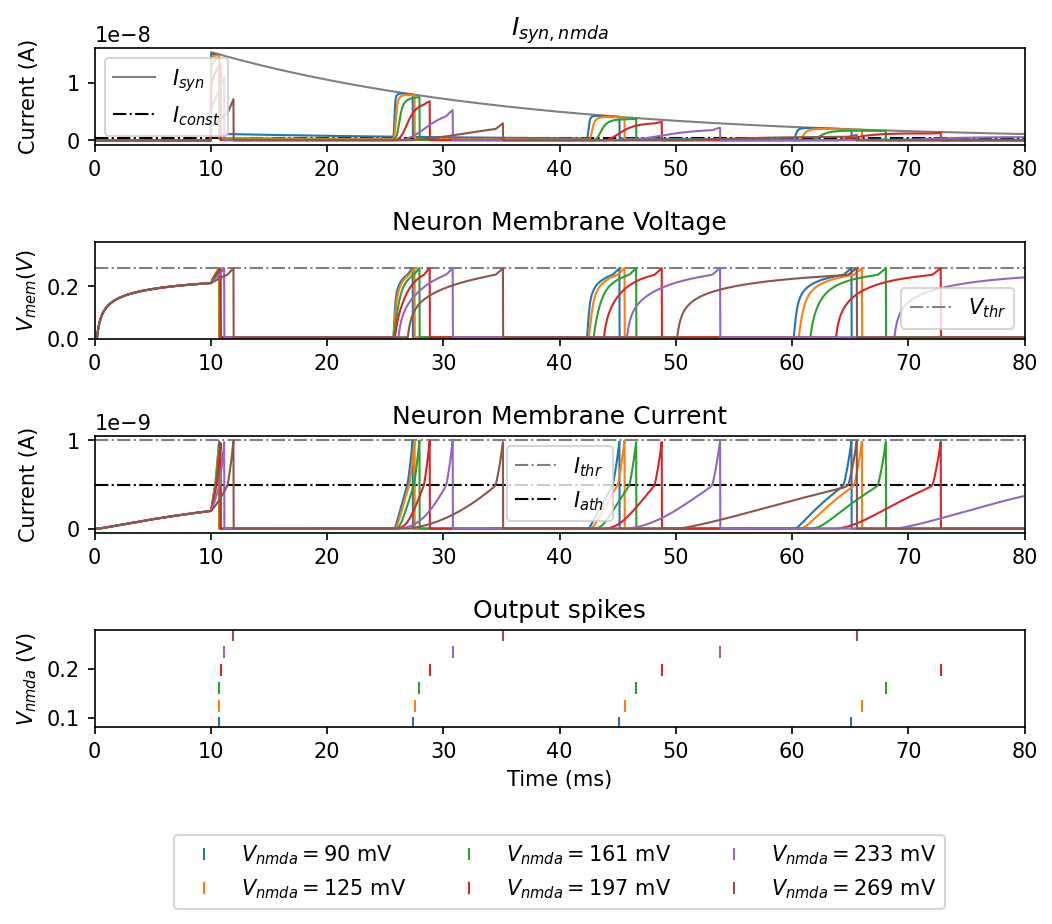

In [4]:
f = plt.figure(figsize=(8,6),dpi=150)
plt.subplots_adjust(hspace=1)

plt.subplot(411)
s = int(1*ms / defaultclock.dt)
plt.plot(mon_neuron_state.t/ms, mon_synapse_nmda.I_syn_nmda[0], linewidth=1, label='$I_{syn}$', color='grey')
plt.hlines(y=dynapse_param['Iconst'], xmin=0, xmax=duration/ms, color='k', linestyles='-.', linewidth=1, label='$I_{const}$')
plt.legend()
for vnmda in range_nmda:
    plt.plot(inmda[vnmda][0], inmda[vnmda][1], linewidth=1)
ylim = plt.ylim()
plt.xlim(0, duration/ms)
plt.ylabel('Current (A)')
plt.title('$I_{syn, nmda}$')

plt.subplot(412)
plt.hlines(y=Vthr, xmin=0, xmax=duration/ms, color='grey', linestyles='-.', linewidth=1, label='$V_{thr}$')
plt.legend()
plt.ylim(0,Vthr+100*mV)
for vnmda in range_nmda:
    p = plt.plot(vmem[vnmda][0], vmem[vnmda][1], linewidth=1)
plt.title('Neuron Membrane Voltage')
plt.ylabel('$V_{mem} (V)$')
plt.xlim(0, duration/ms)


plt.subplot(413)
plt.hlines(y=dynapse_param['Ispkthr']*1e-9/nA, xmin=0, xmax=duration/ms, color='grey', linestyles='-.', linewidth=1)
plt.hlines(y=dynapse_param['Iath']*1e-9/nA, xmin=0, xmax=duration/ms, color='k', linestyles='-.', linewidth=1)
plt.legend(['$I_{thr}$', '$I_{ath}$'])
for vnmda in range_nmda:
    p = plt.plot(imem[vnmda][0], imem[vnmda][1], linewidth=1)
plt.title('Neuron Membrane Current')
plt.ylabel('Current (A)')
plt.xlim(0, duration/ms)
ylim = plt.ylim()


plt.subplot(414)
for vnmda in range_nmda:
    spike_times = out_spikes[vnmda]
    plt.plot(spike_times, [vnmda*mV]*len(spike_times), '|', label='$V_{nmda}=$'+str(vnmda)+' mV')
plt.xlim(0, duration/ms)
plt.title('Output spikes')
plt.ylabel('$V_{nmda}$ (V)')
plt.xlabel('Time (ms)')
plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -1))

f.align_ylabels()
f.savefig(path_to_fig+'/part4_NMDA.pdf')

### A closer look at the Differential Pair of the NMDA synapse

Let's zoom in at time t=10 ms. 

Now we will show how the differential pair block at the output of the DPI acts as a voltage gating mechanism, where the EPSC amplitude $I_{syn, nmda}$ depends on the difference between the membrane potential $V_{mem}$ and the NMDA threshold voltage $V_{nmda}$.

In [5]:
# First, let's compute the DPI output current Isyn and the neuron membrane voltage Vmem @ t=t_spike, i.e. t=10 ms:

# Synaptic current (input to the differential pair):
I_syn_0 = DPI_NMDA_synapse.I_wo_syn_nmda*DPI_NMDA_synapse.weight*DPI_NMDA_synapse.I_g_syn_nmda/(DPI_NMDA_synapse.I_tau_syn_nmda*((DPI_NMDA_synapse.I_g_syn_nmda/Io)+1))

# Neuron Membrane voltage:
# (This voltage depends on the input constant current only. We will use the Vmem trace monitored in the first trial, with Vnmda=90mV)
time = vmem[90][0]
voltage = vmem[90][1]
Vmem_0 = voltage[time<10][-1]

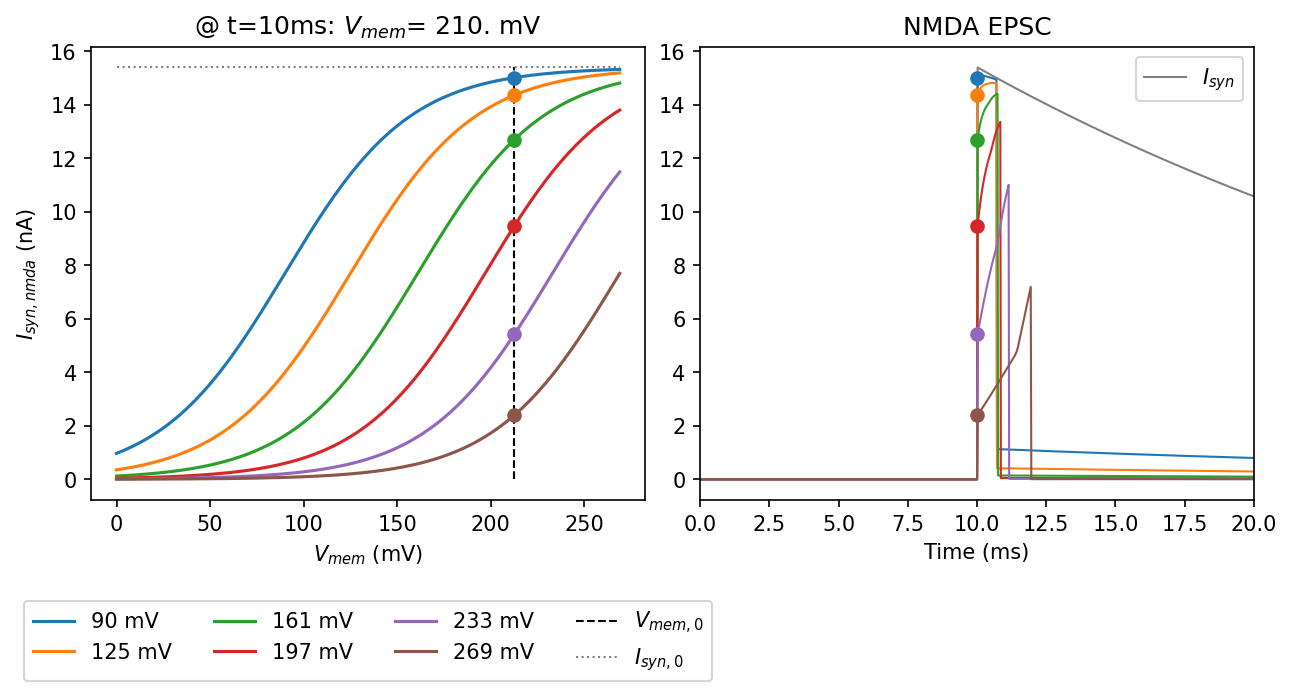

In [6]:
# Plot output of the differential pair at t=t_spike=10ms as a function of V_mem for different V_nmda threshold
f = plt.figure(figsize=(10,4),dpi=150)
plt.subplots_adjust(wspace=.1)
t_end = 20 #ms

# Isyn, nmda vs Vmem:
plt.subplot(121)
vmem = np.arange(0, Vthr/mV)*mV
c={}
for vnmda in range_nmda:
    I_syn_nmda = I_syn_0[0]/(1 + exp(kappa_n*(vnmda*mV-vmem)/Ut))
    p = plt.plot((vmem)/mV, I_syn_nmda/nA, label=str(vnmda)+' mV')
    c[vnmda] = p[0].get_color()
    
plt.vlines(x=Vmem_0/mV, ymin=0, ymax=I_syn_0[0]/nA, linestyle='--', label='$V_{mem,0}$', color='k', linewidth=1)
plt.hlines(y=I_syn_0[0]/nA, xmin=vmem[0]/mV, xmax=vmem[-1]/mV, linestyle='dotted', label='$I_{syn,0}$', color='grey', linewidth=1)
plt.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.2))

inmda_0 = {}
for vnmda in range_nmda:
    inmda_0[vnmda] = I_syn_0[0]/(1 + exp(kappa_n*(vnmda*mV-Vmem_0)/Ut))
    plt.plot(Vmem_0/mV, inmda_0[vnmda]/nA, marker='o', color=c[vnmda])
    plt.ylabel('$I_{syn,nmda}$ (nA)')
    plt.xlabel('$V_{mem}$ (mV)')
    
plt.title('@ t=10ms: $V_{mem}$= '+str(np.round(Vmem_0,2)))


# Isyn, nmda vs Time
plt.subplot(122)
s = int(1*ms / defaultclock.dt)
plt.plot(mon_neuron_state.t/ms, mon_synapse_nmda.I_syn_nmda[0]/nA, linewidth=1, label='$I_{syn}$', color='grey')
plt.legend()
for vnmda in range_nmda:
    plt.plot(inmda[vnmda][0], inmda[vnmda][1]/nA, linewidth=1)
    plt.plot(spike_timing_nmda[0]/ms, (inmda_0[vnmda]+Io)/nA, marker='o', color=c[vnmda])
ylim = plt.ylim()
plt.xlim(0, t_end)
plt.xlabel('Time (ms)')
plt.title('NMDA EPSC')

f.savefig(path_to_fig+'/part4_DP.pdf')

The left plot shows the output of the differential pair, $I_{syn,nmda}$, as a function of $V_{mem}$ for different values of $V_{nmda}$ and for $I_{syn}=I_{syn}$(t=10ms) (horizontal dotted line). 
In our simulation, at t=10 ms, the membrane voltage is $V_{mem}=210$ mV (vertical dashed line). 

Thus, the $I_{syn,nmda}$ value at $V_{mem}=210$ mV is the EPSC at t=10ms, which corresponds to the increment in EPSC at t=10ms (right plot)